# Credit Card Fraud Detection

**Problem statement**: Identifying the fraud transaction

**Description**: Credit card frauds belongs mainly to two groups of application and behavioural fraud.

* **Application Fraud**: Application fraud takes place when, fraudsters apply new cards from bank or issuing
companies using false or other's information. Multiple applications may be submitted by one user with one set of user details or different user with identical details. 

* **Behavioural Fraud**: In this method it takes user behaviour into account. Any activity that is different
from the legitimate user behaviour will be considered as a possible fraud. It does not search for specific patterns

**Dataset**: This dataset is highly imbalance. Only 0.172% of the transaction are fraud.

**Modelling**: 
* Supervised Learning:

    1. Boosting and Tree Algorithms
    2. Neural networks

    
**Metric**:

* Since this dataset is highly unbalance the dominant class can be easily classified. Therefore *precision* and *recall* are the best metric to use.

![Precision and Recall](https://wikimedia.org/api/rest_v1/media/math/render/svg/d37e557b5bfc8de22afa8aad1c187a357ac81bdb)


**Other Techniques**

* Oversampling
* Undersampling
   


In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import plotly.express as px

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, precision_score, recall_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve, train_test_split

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("drive/MyDrive/ML Project/Credit card fraud detection/creditcard.csv")

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
# Check for missing values
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Visualization

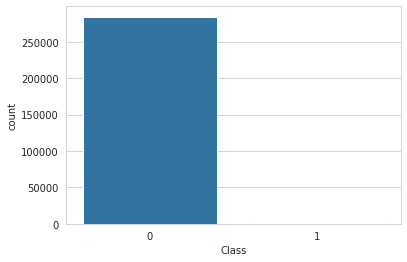

In [6]:
# Check data imbalance
sns.countplot(data['Class'])

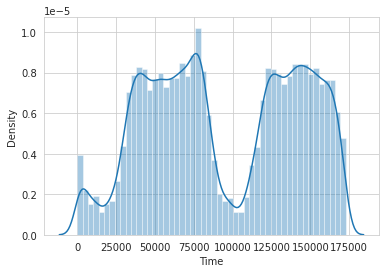

In [7]:
sns.distplot(data['Time']);

In [8]:
# Split the data according to class
class_0 = data[data["Class"] == 0]
class_1 = data[data["Class"] == 1]

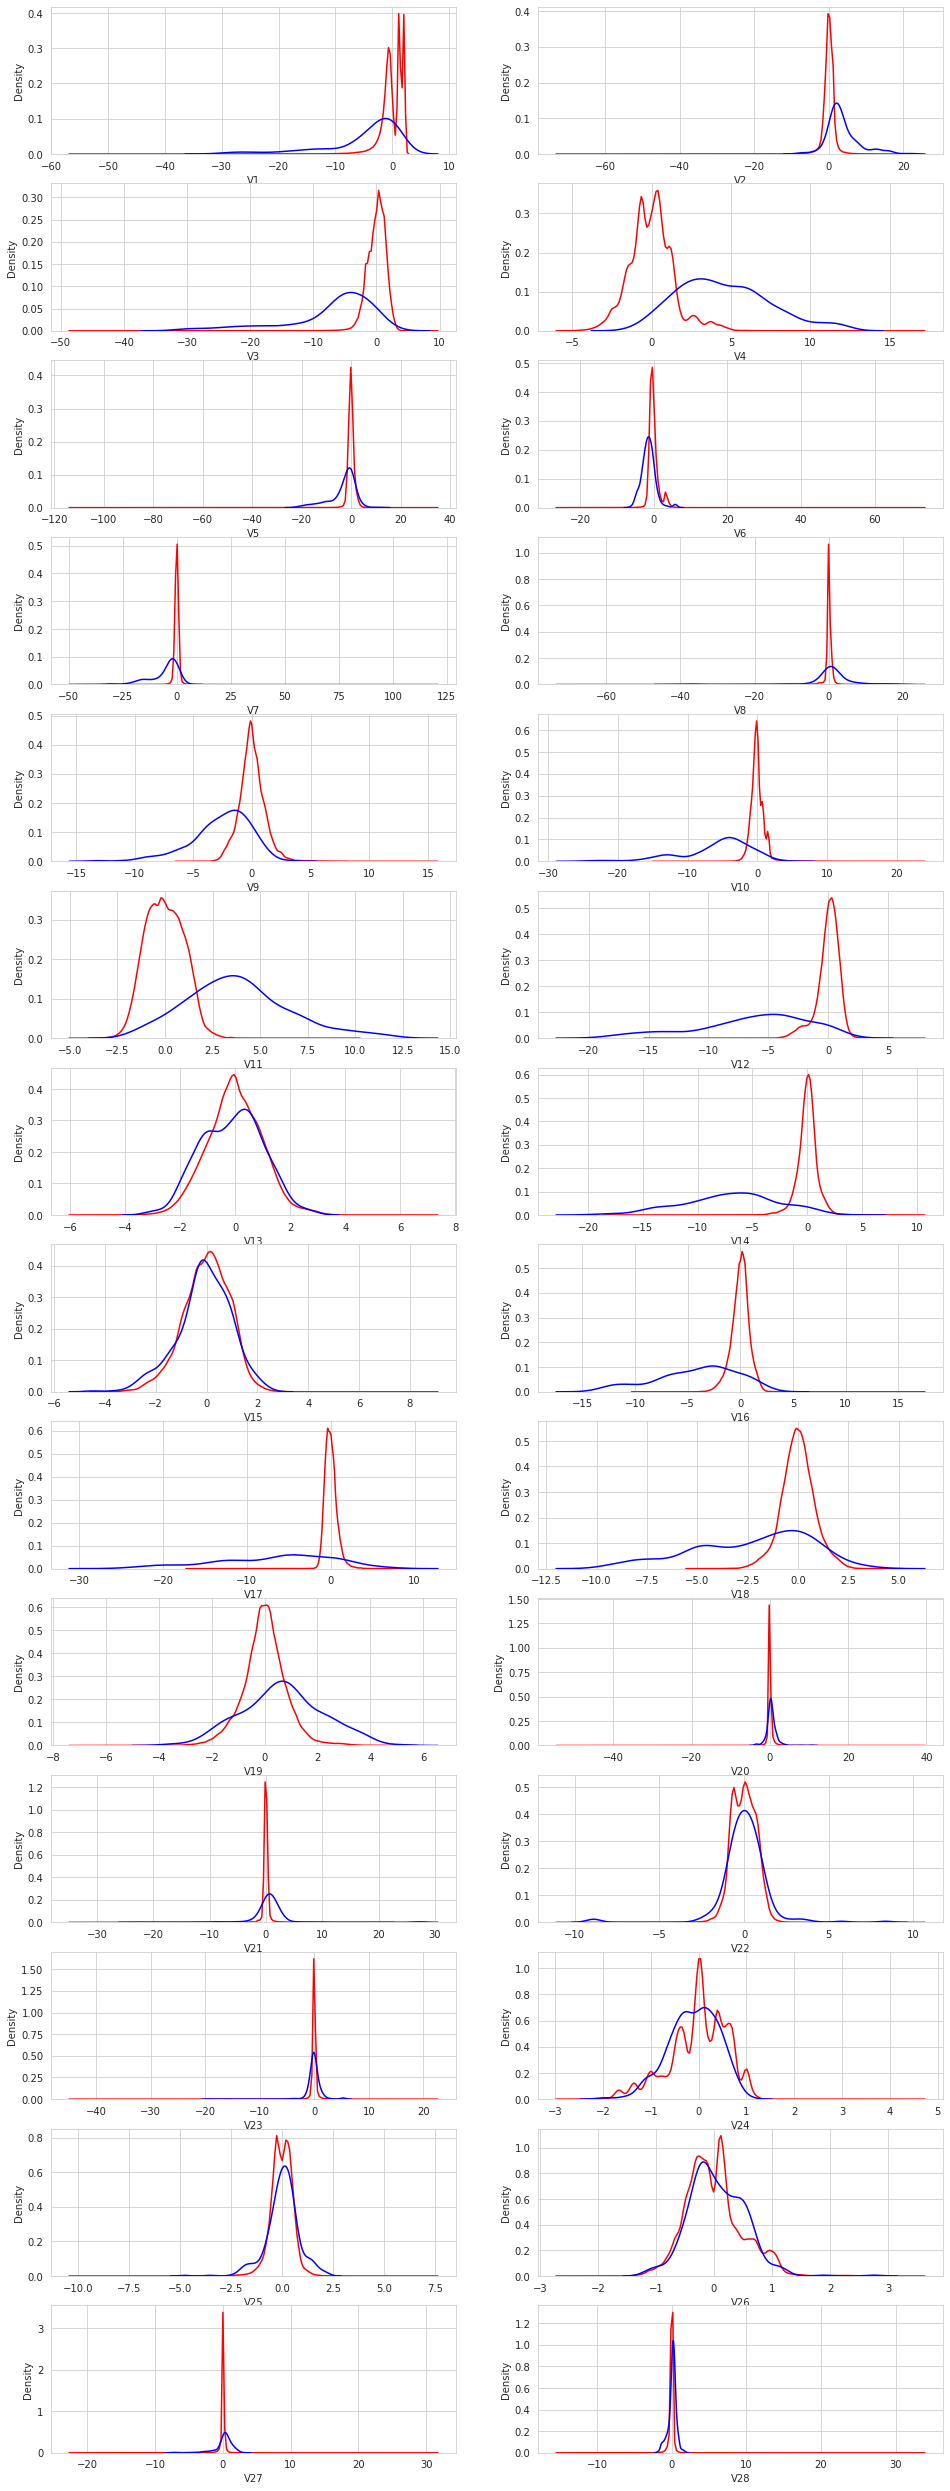

In [9]:
# Visualize features
features = list(data.columns[1:29])
fig, ax = plt.subplots(nrows=14, ncols=2, figsize=(16, 45))
c = 1
for i in features:
    plt.subplot(14, 2, c)
    sns.kdeplot(data=class_0, x=i, color='red')
    sns.kdeplot(data=class_1, x=i, color='blue')
    c = c + 1

Observations:
* From the above garph we can see that most of the features of both the classes differ by a large margin.

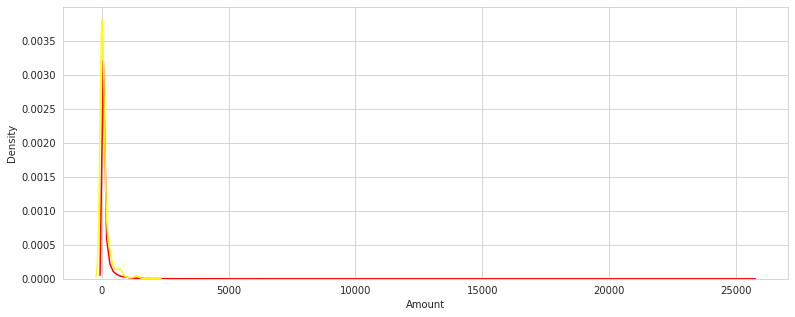

In [10]:
# Visualize amounts
plt.figure(figsize=(13, 5))
sns.kdeplot(data=class_0, x='Amount', color='red')
sns.kdeplot(data=class_1, x='Amount', color='yellow')

## Preprocessing

In [11]:
preprocess_feat = ['Time', 'Amount']
for feat in preprocess_feat:
    scaler = RobustScaler()
    data[feat] = scaler.fit_transform(X=data[feat].values.reshape(-1, 1))

## Modelling

In [12]:
X = data.drop('Class', axis=1)
y = data["Class"]

In [13]:
def Stratified_CV(X, y, classifier, params, folds=5):
    scores = []
    
    # Using Stratified K-fold CV for preserving the percentage of samples for the two classes
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    for fold, (tr_idx, ts_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        x_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        x_ts, y_ts = X.iloc[ts_idx], y.iloc[ts_idx]

        clf = classifier(**params)
        clf.fit(x_tr, y_tr,
                eval_set=[(x_ts, y_ts)],
                early_stopping_rounds=100,
                verbose=False)
        
        pred = clf.predict_proba(x_ts)[:, 1]
        score = roc_auc_score(y_ts, pred)
        precision = precision_score(y_ts, clf.predict(x_ts))
        recall = recall_score(y_ts, clf.predict(x_ts))
        scores.append([score, precision, recall])
        print(f"ROC AUC Score: {score}")
        print()
        print(classification_report(y_ts, clf.predict(x_ts)))
        print()
        
        print("-"*60)
    
    return clf, scores

## Baseline Models

In [14]:
estimators = {
    'KNN':KNeighborsClassifier(),
    'Logistic Regression':LogisticRegression(),
    'SVM': SVC(),
    'Random Forest':RandomForestClassifier(),
    'LightGBM':LGBMClassifier(),
    'XGBoost':XGBClassifier()
}

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
for name, clf in estimators.items():
    print(name)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    
    print(classification_report(y_test, pred))
    print('-'*60)

KNN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56855
           1       0.89      0.78      0.83       107

    accuracy                           1.00     56962
   macro avg       0.95      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------
Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56855
           1       0.87      0.64      0.74       107

    accuracy                           1.00     56962
   macro avg       0.94      0.82      0.87     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------
SVM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56855
           1       0.93      0.74      0.82       107

    accuracy                    

## XGBoost with cross validation

In [17]:
xgb_params = {
    "random_state":42,
    'use_label_encoder':False,
    'eval_metric':'auc'
}

In [18]:
model_xgb, score = Stratified_CV(X, y, XGBClassifier, xgb_params, 5)

Fold: 0
ROC AUC Score: 0.9892530105586048

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.76      0.82        99

    accuracy                           1.00     56962
   macro avg       0.94      0.88      0.91     56962
weighted avg       1.00      1.00      1.00     56962


------------------------------------------------------------
Fold: 1
ROC AUC Score: 0.9769808241925435

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.81      0.86        99

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962


------------------------------------------------------------
Fold: 2
ROC AUC Score: 0.9888225800141909

              precision    recall  f1-score   support

           0       1.00      1.00     

## Neural Network

In [19]:
def NN_CV(model, X, y, folds=5):
    
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    for fold, (tr_idx, ts_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        x_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        x_ts, y_ts = X.iloc[ts_idx], y.iloc[ts_idx]

        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['Recall', 'accuracy']
        )

        es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)
        lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_recall')

        model.fit(x_tr, 
                y_tr,
                validation_data=(x_ts, y_ts),
                verbose=2,
                epochs=30,
                batch_size=128,
                callbacks=[es, lr])
        
        print("-"*100)
    
    return model

In [20]:
def create_model():
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(30, activation='relu', input_shape=(30, )),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [21]:
clf_nn = create_model()
NN_CV(clf_nn, X, y)

Fold: 0
Epoch 1/30
1781/1781 - 8s - loss: 0.0201 - recall: 0.5980 - accuracy: 0.9954 - val_loss: 0.0036 - val_recall: 0.7273 - val_accuracy: 0.9993
Epoch 2/30
1781/1781 - 4s - loss: 0.0031 - recall: 0.7939 - accuracy: 0.9994 - val_loss: 0.0035 - val_recall: 0.7677 - val_accuracy: 0.9993
Epoch 3/30
1781/1781 - 5s - loss: 0.0027 - recall: 0.7939 - accuracy: 0.9994 - val_loss: 0.0037 - val_recall: 0.7374 - val_accuracy: 0.9993
Epoch 4/30
1781/1781 - 4s - loss: 0.0026 - recall: 0.7964 - accuracy: 0.9994 - val_loss: 0.0033 - val_recall: 0.7778 - val_accuracy: 0.9993
Epoch 5/30
1781/1781 - 4s - loss: 0.0023 - recall: 0.8041 - accuracy: 0.9995 - val_loss: 0.0032 - val_recall: 0.7172 - val_accuracy: 0.9994
Epoch 6/30
1781/1781 - 4s - loss: 0.0022 - recall: 0.8066 - accuracy: 0.9995 - val_loss: 0.0032 - val_recall: 0.7273 - val_accuracy: 0.9993
Epoch 7/30
1781/1781 - 5s - loss: 0.0021 - recall: 0.8015 - accuracy: 0.9995 - val_loss: 0.0030 - val_recall: 0.7980 - val_accuracy: 0.9994
Epoch 8/30
1

* From the boosting and neural network we are getting approximately 80% recall.

## Undersampling 

In [22]:
def NN_CV_US(model, X, y, folds=5):
    
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    for fold, (tr_idx, ts_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        x_tr, y_tr = X[tr_idx], y[tr_idx]
        x_ts, y_ts = X[ts_idx], y[ts_idx]

        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['Recall', 'accuracy']
        )

        es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)
        lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_recall')

        model.fit(x_tr, 
                y_tr,
                validation_data=(x_ts, y_ts),
                verbose=2,
                epochs=30,
                batch_size=128,
                callbacks=[es, lr])
        
        print("-"*100)
    
    return model

In [23]:
from imblearn.under_sampling import RandomUnderSampler

In [24]:
rus = RandomUnderSampler()
x_rus, y_rus = rus.fit_resample(X, y)

In [25]:
clf_nn = create_model()
NN_CV_US(clf_nn, x_rus, y_rus)

Fold: 0
Epoch 1/30
7/7 - 1s - loss: 1.4061 - recall: 0.1980 - accuracy: 0.4917 - val_loss: 0.9718 - val_recall: 0.3571 - val_accuracy: 0.5482
Epoch 2/30
7/7 - 0s - loss: 0.9054 - recall: 0.4822 - accuracy: 0.5947 - val_loss: 0.6525 - val_recall: 0.6633 - val_accuracy: 0.6447
Epoch 3/30
7/7 - 0s - loss: 0.5801 - recall: 0.8147 - accuracy: 0.7484 - val_loss: 0.4952 - val_recall: 0.9184 - val_accuracy: 0.7513
Epoch 4/30
7/7 - 0s - loss: 0.4445 - recall: 0.9416 - accuracy: 0.8285 - val_loss: 0.4333 - val_recall: 0.9388 - val_accuracy: 0.8173
Epoch 5/30
7/7 - 0s - loss: 0.3848 - recall: 0.9619 - accuracy: 0.8793 - val_loss: 0.3880 - val_recall: 0.9286 - val_accuracy: 0.8426
Epoch 6/30
7/7 - 0s - loss: 0.3402 - recall: 0.9442 - accuracy: 0.9047 - val_loss: 0.3461 - val_recall: 0.9082 - val_accuracy: 0.8934
----------------------------------------------------------------------------------------------------
Fold: 1
Epoch 1/30
7/7 - 1s - loss: 0.8709 - recall: 0.4949 - accuracy: 0.6086 - val_lo

## Conclusion :



*   Through undersampling we are getting approx 85-90 % recall. 
*   Hyperparameter tuning of xgboost and neural networks can increase recall.

